In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import matplotlib.image as mpimg
import PIL
from PIL import Image
import cv2
from skimage import io, color
import sys
import glob
from scipy.ndimage import rotate
import pandas as pd
import scipy
from scipy.sparse import linalg as lin
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import copy
%matplotlib inline

In [81]:
def image_seq_to_video(imgs_path, output_path='./video.mp4', fps=15.0):
    output = output_path
    img_array = []
    for filename in glob.glob(os.path.join(imgs_path, '*.jpg')):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        # img = cv2.resize(img, (width // 2, height // 2))
        img = cv2.resize(img, (width, height))
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)

    print(size)
    print("writing video...")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lower case
    out = cv2.VideoWriter(output, fourcc, fps, size)
    # out = cv2.VideoWriter('project.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    print("saved video @ ", output)

# STYLE Transfer

In [22]:
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([transforms.Resize(imsize),
    transforms.ToTensor()])

In [23]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
path_images_im = os.path.join("my_data", "video", "images","vid_im","0000.jpg")

In [26]:
dbz_image = image_loader(path_images_im)

In [27]:
Namek_style = image_loader(os.path.join("my_data", "video", "Namek.jpg"))

In [28]:
assert Namek_style.size() == dbz_image.size(), \
    "we need to import style and content images of the same size"
unloader = transforms.ToPILImage()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

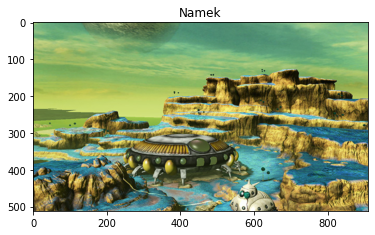

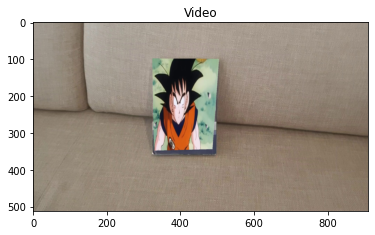

In [29]:
plt.figure()
imshow(Namek_style, title='Namek')
plt.figure()
imshow(dbz_image, title='Video')

In [30]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [31]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [32]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [33]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [34]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [35]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [36]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [38]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [45]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=150,
                       style_weight=10000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)
    return input_img

In [79]:
for i in range(303):
    fname = str(i).zfill(4)
    path_images_im = os.path.join("my_data", "video", "images","vid_im",fname+".jpg")
    try:
        dbz_image = image_loader(path_images_im)
        input_img = dbz_image.clone()
        output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                dbz_image, Namek_style, input_img)
        im_s(output, fname)
    except:
        continue

my_data\video\images\vid_im\0278.jpg
Building the style transfer model..
Optimizing..


C:\Users\orene\anaconda3\envs\CV\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\orene\anaconda3\envs\CV\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 2.295097 Content Loss: 7.571279

run [100]:
Style Loss : 1.431065 Content Loss: 7.005918

run [150]:
Style Loss : 6.102551 Content Loss: 7.573128

my_data\video\images\vid_im\0279.jpg
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2.329964 Content Loss: 7.519091

run [100]:
Style Loss : 1.464053 Content Loss: 6.944509

run [150]:
Style Loss : 1.354255 Content Loss: 6.845779

my_data\video\images\vid_im\0280.jpg
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2.194061 Content Loss: 7.529478

run [100]:
Style Loss : 1.450610 Content Loss: 6.916356

run [150]:
Style Loss : 1.351497 Content Loss: 6.773272

my_data\video\images\vid_im\0281.jpg
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2.237038 Content Loss: 7.518028

run [100]:
Style Loss : 1.451695 Content Loss: 6.925590

run [150]:
Style Loss : 1.322988 Content Loss: 7.054566

my_data\video\images\vid_im\0282.jpg
Building the style transf

In [73]:
def im_s(tensor, fname, output_path = os.path.join("my_data", "video", "images","style")):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    image.save(os.path.join(output_path, fname + ".jpg"))

In [82]:
image_seq_to_video(os.path.join("my_data", "video", "images","style"), './my_data/video.mp4', fps=30.0)

(910, 512)
writing video...
saved video @  ./my_data/video.mp4
